# _Bird Image Classification_


In [1]:
# Import everything we want
import os
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpi
%matplotlib inline
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

from torchvision import transforms
from torchvision import models
from torch import optim
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [2]:
# Lets defing all the paths
main_dir = "/kaggle/input/100-bird-species/"
train_dir = "/kaggle/input/100-bird-species/train/"
test_dir = "/kaggle/input/100-bird-species/test/"
val_dir = "/kaggle/input/100-bird-species/valid/"

In [3]:
# Now let see the images
transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load your datasets
trainset = ImageFolder(root=train_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

testset = ImageFolder(root=test_dir, transform=transform)
testloader = DataLoader(testset, batch_size=64, num_workers=0, shuffle=False)

datasizes = {
    "train": len(trainset),
    "test": len(testset)
}


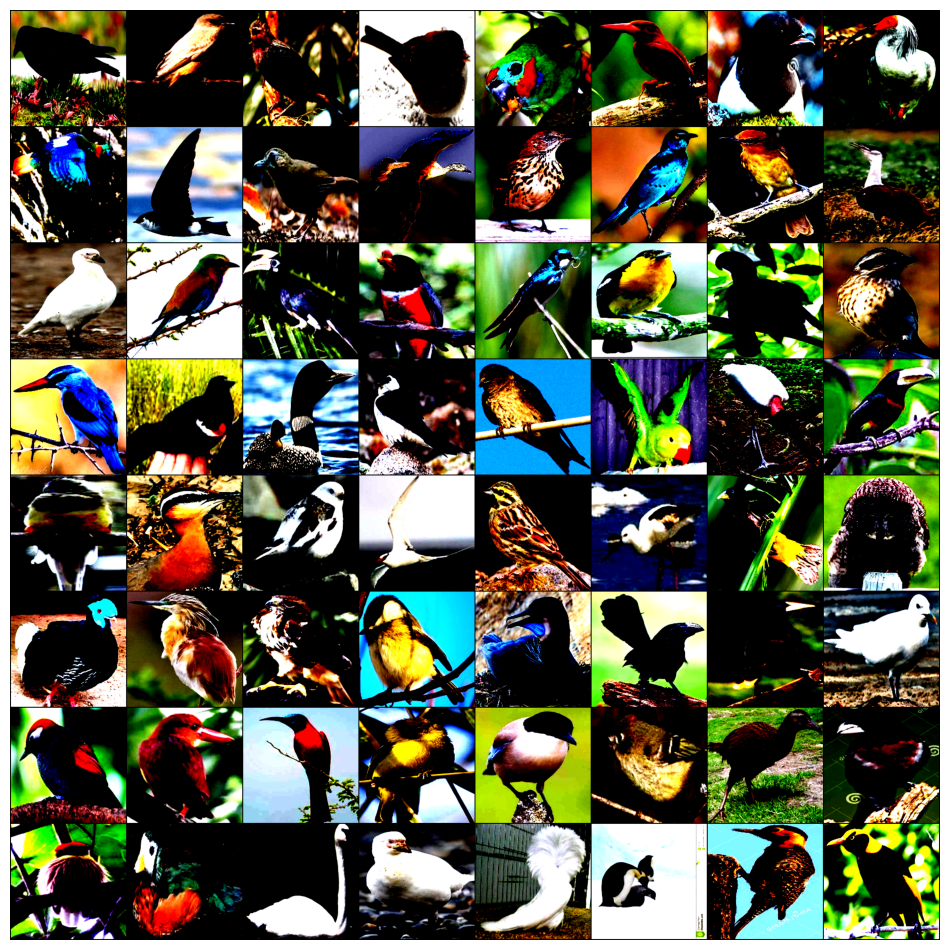

In [4]:
# birds image visualize in a grid
def visualize_batch(batch, brightness_factor=1.5, contrast_factor=1.5):
    # Adjust brightness and contrast of each image in the batch
    adjusted_batch = batch * brightness_factor  # Adjust brightness
    mean = torch.mean(adjusted_batch, dim=[2, 3], keepdim=True)
    adjusted_batch = (adjusted_batch - mean) * contrast_factor + mean  # Adjust contrast

    # Ensure pixel values are within valid range [0, 1]
    adjusted_batch = torch.clamp(adjusted_batch, 0, 1)

    # Create the grid image
    grid_img = make_grid(adjusted_batch, nrow=8)

    # Plot the grid image
    plt.figure(figsize=(12, 15))
    plt.imshow(np.transpose(grid_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
# Get a batch of images from the trainloader
images, _ = next(iter(trainloader))

# Visualize the batch of images
visualize_batch(images)

In [5]:
# Now Defining the model
model = models.resnet18(pretrained=True)
CLASSES = trainset.classes
num_classes = len(CLASSES)
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device) 

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.7MB/s]


In [6]:
# Training the model 
%%time
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device) 

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * inputs.size(0)

        
    # Print epoch statistics
    epoch_loss = running_loss / datasizes['train']
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

UsageError: Line magic function `%%time` not found.


In [ ]:
# Evaluation on test dataset
model.eval()  
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device) 

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {(100 * correct / total):.2f}%")

In [ ]:
# Let's save the model
torch.save(model.state_dict(),"model.pth" )